## Categorization of Websites using LSTM

In this notebook, let us discuss in detail how to build an RNN model for classifying text in python using the keras framework.


## Table of Contents
 - Problem Statement
 - Data set
 - Preprocessing
     - Cleaning
     - Label Encoding
     - Validation split
     - Padding
 - Model building
     - LSTM
     - GRU
     - Comparison: LSTM vs GRU 

### Problem Statement

- Classification of Web page content is vital to many tasks in Web information retrieval such as maintaining Web directories and focused crawling. 
- The uncontrolled nature of Web content presents additional challenges to Web page classification as compared to traditional text classification since there can be many kind of noise present in the data apart from text.
- The objective is to build a model that classifies the webpages into different tags based on the text in the webpage.

**Import required libraries**

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/sanad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### About the Data set
- Let us look at the first 5 rows 

In [4]:
new_train=pd.read_csv("web_categ_final.csv")
new_train.shape

(53447, 3)

In [20]:
new_train.head()

,Webpage_id,Tag,text
0,1,news,b' Skip to main content ...
1,2,news,b' Skip to main content ...
2,3,news,b' Skip to main content ...
3,4,news,"b"" Skip to main content ..."
4,5,news,"b"" Skip to main content ..."


Let us look at the frequency of each label

In [3]:
new_train['Tag'].value_counts()

others            17417
news               7992
publication        7705
profile            5196
conferences        4666
forum              4503
clinicalTrials     2839
thesis             1800
guidelines         1329
Name: Tag, dtype: int64

### Preprocessing

1.The raw data is messy. It contains links, non ascii characters, punctuations, numbers, extra spaces, etc.

2.So, Data Pre-processing is the most important step prior to the model building in which we remove all the unnecessary qualities from the data.


### 1. Cleaning

**Steps** 

1.Convert to lowercase

2.Removal of links

3.Removal of text inside {} and ()

4.Removal of special characters, punctuations, numbers

5.Removal of short words

In [4]:
for text in new_train['text'][:5]:
    print("\n\n",text)



 b'    Skip to main content                                    Twitter  LinkedIn      Search           Top Menu    DDF 2017    FierceBiotech    Jobs    Resources    Events    Subscribe                  Main navigation    Pharma    M&A    Regulatory    Financials    Corporate    Legal      Manufacturing    M&A    Outsourcing    Regulatory    Supply Chain    Partnering    Drug Safety      Marketing    Regulatory    DTC Advertising    Digital and Social Media    Data and Analytics    Launches      Pharma Asia    M&A    R&D    Regulatory    Sales and Marketing    Financials    Manufacturing      Animal Health    R&D    M&A    Regulatory    Veterinarian    Financials    Vaccines      Drug Delivery    R&D    Regulatory    Partnering      Vaccines    Deals    Infectious Diseases    R&D    Regulatory        Main navigation - Mobile    Pharma    M&A    Regulatory    Financials    Corporate    Legal      Manufacturing    M&A    Outsourcing    Regulatory    Supply Chain    Partnering    Drug Sa

In [5]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text):
    #converting to lowercase
    newString = text.lower()
    #removing links
    newString = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', newString) 
    #removing text inside ()
    newString = re.sub(r'\([^)]*\)', '', newString)
    #removing text inside []
    newString = re.sub(r'\{[^)]*\}', '', newString)
    #fetching alphabetic characters
    newString = re.sub("[^a-zA-Z]", " ", newString)
    #removing stop words
    tokens = [w for w in newString.split() if not w in stop_words] 
    long_words=[]
    for i in tokens:
        #removing short words
        if len(i)>=4:                                                 
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [6]:
text1 = new_train['text'][2]
clean_text1 = text_cleaner(text1)
print("Before cleaning:\n",text1)
print("After cleaning:\n",clean_text1)

Before cleaning:
 b'    Skip to main content                                    Twitter  LinkedIn      Search           Top Menu    DDF 2017    FierceBiotech    Jobs    Resources    Events    Subscribe                  Main navigation    Pharma    M&A    Regulatory    Financials    Corporate    Legal      Manufacturing    M&A    Outsourcing    Regulatory    Supply Chain    Partnering    Drug Safety      Marketing    Regulatory    DTC Advertising    Digital and Social Media    Data and Analytics    Launches      Pharma Asia    M&A    R&D    Regulatory    Sales and Marketing    Financials    Manufacturing      Animal Health    R&D    M&A    Regulatory    Veterinarian    Financials    Vaccines      Drug Delivery    R&D    Regulatory    Partnering      Vaccines    Deals    Infectious Diseases    R&D    Regulatory        Main navigation - Mobile    Pharma    M&A    Regulatory    Financials    Corporate    Legal      Manufacturing    M&A    Outsourcing    Regulatory    Supply Chain    Partne

In [7]:
cleaned_text=[]
for i in new_train['text']:
    cleaned_text.append(text_cleaner(i))    

### 2. Label Encoding
Let us convert the output label to integer using label encoder

In [21]:
new_train['Tag']

0           news
1           news
2           news
3           news
4           news
5           news
6           news
7           news
8           news
9           news
10          news
11          news
12          news
13          news
14          news
15          news
16          news
17          news
18          news
19          news
20          news
21          news
22          news
23          news
24          news
25          news
26          news
27          news
28          news
29          news
          ...   
53417    profile
53418    profile
53419    profile
53420    profile
53421    profile
53422    profile
53423    profile
53424    profile
53425    profile
53426    profile
53427    profile
53428    profile
53429    profile
53430    profile
53431    profile
53432    profile
53433    profile
53434    profile
53435    profile
53436    profile
53437    profile
53438    profile
53439    profile
53440    profile
53441    profile
53442    profile
53443    profile
53444    profi

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(new_train['Tag'])

In [23]:
y

array([4, 4, 4, ..., 6, 6, 6])

### 3. Validation Split
Let us split the dataset in the ratio of 7:3 and evaluate the performance of model on 30% of the data

In [24]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(cleaned_text,y,test_size=0.3,random_state=0,shuffle=True) 

### 4. Padding

**Distribution of sequences**

Here, we create the distribution for the length of the sequences and fix the maximum length of sequence which is required for building the model

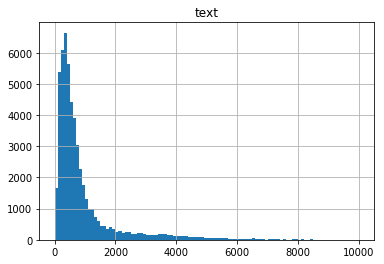

In [11]:
import matplotlib.pyplot as plt

text_word_count = []

#populate the lists with sentence lengths
for i in cleaned_text:
      text_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count})

length_df.hist(bins = 100, range=(0,10000))
plt.show()

From the above histogram, we observe that most of the sequences fall under the length of 500. So, let us fix maximum length of sequence to 500.

In [9]:
max_len=500

**Preparing Tokenizer**

1.Here, we create the vocabulary ( refers to all the unique words in the entire dataset) and assign index to every unique word.

2.Using the word index, we convert the word sequence to integer sequence.

3.Append zero upto the maximum length of sequence so that all the sequences are of same length

In [20]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
#creating index for a wor
tokenizer.fit_on_texts(list(x_tr))

#converting word seq to integer seq
x_tr    =   tokenizer.texts_to_sequences(x_tr) 
x_val   =   tokenizer.texts_to_sequences(x_val)

#padding up with zero 
x_tr    =   pad_sequences(x_tr,  maxlen=max_len, padding='post')
x_val   =   pad_sequences(x_val, maxlen=max_len, padding='post')

vocabulary   =  len(tokenizer.word_index) +1
print("Vocabulary size:",vocabulary)

Using TensorFlow backend.


Vocabulary size: 467704


In [39]:
#sequence encoding and padding
x_tr[7128]

array([   364,    178,     91,    959,   2157,    362,     35,   1506,
          419,   1398,   1561,    419,    319,    319,   2587,    319,
         3589,   1852,    357,     77,    279,     77,    141,    123,
          163,    371,    279,     48,     71,     10,    809,    321,
          447,     33,    212,     33,   7673,   5287,   2394,    140,
           70,    380,    350,     19,     10,    312,     99,    212,
         2779,   1987,   1225,     91,    268,    357,    160,    323,
         7047,     44,   8007,    166,   2979,     16,    106,     16,
          226,     91,      7,    565,     59,   1529,     48,      7,
          565,     59,     16,    180,     16,    265,      7,    232,
            7,    202,    415,    163,   1831,    153,    156,      7,
           62,    162,    111,    826,   5202,     70,   3961,    153,
         2642,    530,      9,   2642,   1236,      9,    709,    273,
           93,    281,    843,   3025,    843,    622,   4311,     14,
      

In [40]:
#showing word index 
tokenizer.word_index

{'cancer': 1,
 'health': 2,
 'research': 3,
 'patients': 4,
 'google': 5,
 'pubmed': 6,
 'article': 7,
 'cells': 8,
 'view': 9,
 'information': 10,
 'scholar': 11,
 'clinical': 12,
 'cell': 13,
 'study': 14,
 'care': 15,
 'search': 16,
 'conference': 17,
 'medical': 18,
 'contact': 19,
 'treatment': 20,
 'patient': 21,
 'data': 22,
 'medicine': 23,
 'news': 24,
 'university': 25,
 'disease': 26,
 'also': 27,
 'science': 28,
 'international': 29,
 'results': 30,
 'development': 31,
 'home': 32,
 'journal': 33,
 'time': 34,
 'email': 35,
 'using': 36,
 'management': 37,
 'group': 38,
 'share': 39,
 'site': 40,
 'expression': 41,
 'center': 42,
 'services': 43,
 'find': 44,
 'analysis': 45,
 'human': 46,
 'products': 47,
 'authors': 48,
 'policy': 49,
 'hospital': 50,
 'global': 51,
 'overview': 52,
 'central': 53,
 'free': 54,
 'first': 55,
 'tumor': 56,
 'related': 57,
 'studies': 58,
 'abstract': 59,
 'society': 60,
 'people': 61,
 'full': 62,
 'support': 63,
 'used': 64,
 'media': 65,

The output labels are converted into one hot vectors.

In [41]:
from keras.utils.np_utils import to_categorical
y_tr=to_categorical(y_tr,num_classes=9)
y_val=to_categorical(y_val,num_classes=9)

### Model building

Let us discuss about few terms and layers which are required prior to model building

Keras is an open source deep learning library written in python. There are 2 ways of building models in keras i.e. Sequential API and Functional API

**Sequential API**

Here, we can add only one model in the same layer.  

**Functional API**

Here, we can add multiple models in the same layer.

**keras embedding layer**

Embedding Layer creates the embedding matrix which maps the integer to the embeddings. These embeddings are learnt during back propagation

The below image gives the intuition of the keras embedding layer

<img src="embeddings.JPG">

**Dropout**

Dropout is a regularization technique which randomly dropouts neurons from the layer and the connections to these neurons are disabled and not involved in forward as well as the backward propagation

**Recurrent dropout**

This is used in Recurrent Neural Networks to dropout recurrent hidden units between the timesteps

Now, let us build the sequential model for text classification

### 1. LSTM Model

Let's start with an LSTM model first and then we will build a GRU model with the same architecture and hyper-parameters to compare the performance of both the models.
<img src="model.JPG">

In [42]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
K.clear_session()

# LSTM model
model=Sequential()
model.add(Embedding(vocabulary,100,input_length=max_len,trainable=True, mask_zero=True)) 
model.add(LSTM(300,dropout=0.1, recurrent_dropout=0.2)) 
model.add(Dense(64,activation='relu')) 
model.add(Dense(9,activation='softmax')) 
print(model.summary()) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          46770400  
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               481200    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                19264     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 585       
Total params: 47,271,449
Trainable params: 47,271,449
Non-trainable params: 0
_________________________________________________________________
None


Let us compile the model by specifying optimizer, loss and metrics

Here, i am using categorical_crossentropy as loss function since it is-multi classification problem

In [43]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=["acc"]) 

**Callbacks**

I define 2 callbacks here i.e. Early Stopping and Model Checkpoint

**Early Stopping**

This helps us in stopping the neural network at the right time. The training of neural network is stopped as the validation loss keeps increasing for some epochs which is specified using patience parameter

**Model Checkpoint**

The model obtained at the end of training is not the best model since the training of the model is stopped after the increase in validation loss.

This helps in saving the best model at every epoch which can retrieved while making predictions

In [44]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)  
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)  

Let us fit the model to the training data and evaluate on hold out set.

In [15]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=1200,epochs=100,validation_data=(np.array(x_val),np.array(y_val)),verbose=1,callbacks=[es,mc])

Train on 37412 samples, validate on 16035 samples
Epoch 1/100
37412/37412 [==============================] - 76s 2ms/step - loss: 2.0234 - acc: 0.3693 - val_loss: 1.6284 - val_acc: 0.3655

Epoch 00001: val_loss improved from inf to 1.62843, saving model to best_model.h5
Epoch 2/100
37412/37412 [==============================] - 72s 2ms/step - loss: 1.2358 - acc: 0.5792 - val_loss: 0.8153 - val_acc: 0.7280

Epoch 00002: val_loss improved from 1.62843 to 0.81533, saving model to best_model.h5
Epoch 3/100
37412/37412 [==============================] - 73s 2ms/step - loss: 0.6236 - acc: 0.7906 - val_loss: 0.4976 - val_acc: 0.8248

Epoch 00003: val_loss improved from 0.81533 to 0.49762, saving model to best_model.h5
Epoch 4/100
37412/37412 [==============================] - 73s 2ms/step - loss: 0.4085 - acc: 0.8629 - val_loss: 0.4093 - val_acc: 0.8551

Epoch 00004: val_loss improved from 0.49762 to 0.40929, saving model to best_model.h5
Epoch 5/100
37412/37412 [=============================

**Diagnostic Plots**

The diagnostic plots helps in understanding the performance of the model over time

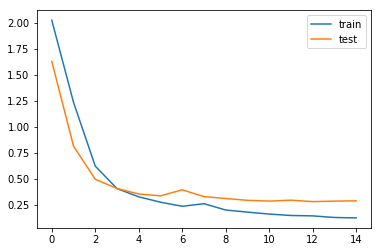

In [16]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

- From the above plot, we can infer that the validation loss has increased after epoch 8. Hence, the training is stopped at the end of epoch 10. 

- We can also observe that model obtained after epoch 10 is not the best model since the validation loss has increased. Hence, we make use of model checkpoint.
- Let us retrieve the best model and make predictions on the validation data.

In [17]:
from keras.models import load_model
model = load_model('best_model.h5')

In [18]:
from sklearn.metrics import classification_report

y_pred=model.predict_classes(np.array(x_val))
y_true = np.argmax(y_val, axis=1)
print(classification_report(y_true,y_pred))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98       868
          1       0.91      0.89      0.90      1408
          2       0.99      0.99      0.99      1364
          3       0.96      0.87      0.91       389
          4       0.84      0.87      0.85      2425
          5       0.88      0.90      0.89      5241
          6       0.93      0.86      0.89      1556
          7       0.95      0.94      0.95      2257
          8       1.00      1.00      1.00       527

avg / total       0.91      0.91      0.91     16035



### 2. GRU Model

In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
K.clear_session()

# GRU model
model2=Sequential()
model2.add(Embedding(vocabulary,100,input_length=max_len,trainable=True, mask_zero=True)) 
model2.add(GRU(300,dropout=0.1, recurrent_dropout=0.2)) 
model2.add(Dense(64,activation='relu')) 
model2.add(Dense(9,activation='softmax')) 
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          46770400  
_________________________________________________________________
gru_1 (GRU)                  (None, 300)               360900    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                19264     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 585       
Total params: 47,151,149
Trainable params: 47,151,149
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
# compile model
model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=["acc"]) 

# checkpoints 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)  
mc=ModelCheckpoint('best_model_gru.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)  

# model history
history2 = model2.fit(np.array(x_tr),np.array(y_tr),batch_size=1200,epochs=100,validation_data=(np.array(x_val),np.array(y_val)),verbose=1,callbacks=[es,mc])

Train on 37412 samples, validate on 16035 samples
Epoch 1/100
37412/37412 [==============================] - 50s 1ms/step - loss: 2.0347 - acc: 0.3760 - val_loss: 1.7656 - val_acc: 0.4732

Epoch 00001: val_loss improved from inf to 1.76563, saving model to best_model_gru.h5
Epoch 2/100
37412/37412 [==============================] - 48s 1ms/step - loss: 1.3873 - acc: 0.5569 - val_loss: 0.9887 - val_acc: 0.7026

Epoch 00002: val_loss improved from 1.76563 to 0.98873, saving model to best_model_gru.h5
Epoch 3/100
37412/37412 [==============================] - 48s 1ms/step - loss: 0.7410 - acc: 0.7788 - val_loss: 0.5766 - val_acc: 0.8148

Epoch 00003: val_loss improved from 0.98873 to 0.57664, saving model to best_model_gru.h5
Epoch 4/100
37412/37412 [==============================] - 48s 1ms/step - loss: 0.4682 - acc: 0.8534 - val_loss: 0.4609 - val_acc: 0.8429

Epoch 00004: val_loss improved from 0.57664 to 0.46089, saving model to best_model_gru.h5
Epoch 5/100
37412/37412 [=============

- Let us retrieve the best model and make predictions on the validation data.

In [16]:
from keras.models import load_model

# load best model
model = load_model('best_model_gru.h5')

# make predictions
from sklearn.metrics import classification_report

y_pred=model.predict_classes(np.array(x_val))
y_true = np.argmax(y_val, axis=1)
print(classification_report(y_true,y_pred))

             precision    recall  f1-score   support

          0       0.99      0.95      0.97       868
          1       0.90      0.88      0.89      1408
          2       0.99      0.99      0.99      1364
          3       0.92      0.86      0.89       389
          4       0.86      0.87      0.87      2425
          5       0.90      0.92      0.91      5241
          6       0.94      0.87      0.90      1556
          7       0.93      0.94      0.93      2257
          8       0.99      1.00      0.99       527

avg / total       0.92      0.92      0.92     16035



We have seen how to build deep learning model for multi classification problem by covering all the necessary details of implementation in python using keras

### 3. Comparison: LSTM vs GRU

 - GRU takes approx. 40% of lesser training time for similar performance.
 - LSTM might be good for more complex problems like Machine Translation.
 - GRU should be preferred when experimenting.